# ISTA: Applied Deep Learning for Scientists -- Homework 3

**Topics**: Diffusion models, Langevin dynamics, and variational inference.

This homework consists of a total of 6 tasks. They are mostly coding ones, except for Task 5.

For the theoretical questions, you can type out the answers in cells dedicated for the answers (Markdown supports LaTeX equations).
For the practical question, please fill in the missing blocks of code.
Please submit the homeworks via email to **all** the TAs with "[ADL HW3]" as subject. *Please also note that Valentino's e-mail is not the ISTA one anymore*.


Deadline: April 17, 2024, 11:55 PM.

TAs: Dingling Yao (dingling.yao@ist.ac.at), Valentino Maiorca (maiorca@di.uniroma1.it), Sanketh Vedula (sanketh@campus.technion.ac.il)

Name: < your name >

# Homework 3: Diffusion models


The goal of this question is to sample from a simple multivariate Normal distribution via its score function.

We define $\mathbf{x} \sim N(\mathbf{\mu}, \mathbf{\Sigma})$, where $\mathbf{\mu} = \mathbf{0}$ and $\mathbf{\Sigma} = \left[\begin{matrix} 1.0 & -0.7 \\ -0.7 & 1.0 \end{matrix}\right]$.

Sampling via Langevin dynamics is given by the following iteration:
$$
\mathbf{x}_{k+1} = \mathbf{x}_k + \frac{\tau}{2} \cdot \nabla_\mathbf{x} p(\mathbf{x}_k) + \sqrt{\tau} \cdot \mathbf{z}_k,
$$
where $\mathbf{z}_k \sim N(\mathbf{0}, \mathbf{I})$, and $p(\mathbf{x}_k)$ is the pdf of $\mathbf{x}$. This process is run to draw one sample from $\mathbf{x}$.


**Task 1**: Implement the `score()` function in the `AntiCorrelatedGaussian` class below.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm


class AntiCorrelatedGaussian:
    def __init__(self):
        self._mu = np.zeros(2)
        self._sigma = np.array([[1.0, -0.7], [-0.7, 1.0]])

    def score(self, x: np.array) -> np.array:
        """Compute the score of the AntiCorrelatedGaussian distribution at x."""
        # TODO: Task 1. Implement the score function.

    def sample(self, n: int) -> np.array:
        return np.random.multivariate_normal(self._mu, self._sigma, size=n)

**Task 2**: Implement the Langevin sampler. You just need to fill in the update rule in the `langevin_sampler()` function. 

$$
\mathbf{x}_{k+1} = \mathbf{x}_k + \frac{\tau}{2} \cdot \nabla_\mathbf{x} p(\mathbf{x}_k) + \sqrt{\tau} \cdot \mathbf{z}_k,
$$

In [ ]:
def langevin_sampler(score_fn, n, K=20, return_trajectory: bool = False):
    """
    Implements the langevin dynamics sampling..

    Args:
      score_fn: the score function we would like to sample from.
      n: number of samples to draw.
      k: num iterations

    Return:
      converged samples from Langevin iterations.
    """
    t_0, t_1 = 0.0, 1.0
    t = np.linspace(t_1, t_0, K)
    x = np.zeros((n, 2, K))
    x[:, :, 0] = 2 * np.random.normal(size=(n, 2))
    for i in tqdm(range(1, K)):
        x_t_minus_1 = x[:, :, i - 1]
        x[:, :, i] = ...  # TODO: Task 2. Implement the Langevin dynamics update.
    return x[:, :, -1] if not return_trajectory else x

In [ ]:
dist = AntiCorrelatedGaussian()
est_samples = langevin_sampler(
    score_fn=dist.score,
    n=1000,
)
gt_samples = dist.sample(n=1000)


# Scatter plot the results -- do they look alike? They should.
plt.figure()
plt.scatter(est_samples[:, 0], est_samples[:, 1], s=2, color="blue", label="EST")
plt.scatter(gt_samples[:, 0], gt_samples[:, 1], s=2, color="red", label="GT")
plt.legend()
plt.show()

##  Denoising diffusion models


In the previous question, we knew the distribution in its parametric form.

Now we will work with a more complicated setting where the distribution is not available to us in its parametric form, but we are only provided with a few samples drawn from it, i.e., we have $\{ \mathbf{x} \}_{i=1}^{N} \sim p(\mathbf{x})$. The goal is to build a generative model to model $p(\mathbf{x})$.

In [ ]:
from sklearn.datasets import make_swiss_roll

# Sample a batch from the swiss roll
def sample_batch(size, noise=0.5):
    x, _ = make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0


data = sample_batch(10**4).T
plt.figure(figsize=(5, 5))
plt.scatter(*data, alpha=0.5, color="red", edgecolor="white", s=10)
plt.show()

### Denoising score matching

We will model the distribution via a neural network that models its score. We will train the score network via *denoising score matching*.

Denote the score network by $F_\theta$. Define $q_\sigma(\bar{\mathbf{x}} | \mathbf{x})$ to be a corruption applied to $\mathbf{x}$.

In [Vincent et al. 2011](http://www-labs.iro.umontreal.ca/~vincentp/Publications/smdae_techreport_1358.pdf), it was shown that $F_\theta = \nabla_\mathbf{x} \log q_\sigma(\mathbf{x}) \approx \nabla_\mathbf{x} \log p(\mathbf{x})$ is the minimizer of the following objective
$$
\mathbb{E}_{q_\sigma(\bar{\mathbf{x}}|\mathbf{x})} \left[ \mathbb{E}_{p(\mathbf{x})}\left[ F_\theta(\bar{\mathbf{x}}) - \nabla_{\bar{\mathbf{x}}} \log q_\sigma (\bar{\mathbf{x}} | \mathbf{x}) \right] \right].
$$
Assuming
$$
q_\theta (\bar{\mathbf{x}} | \mathbf{x}) = N(\mathbf{x}, \sigma^2 \mathbf{I}), $$
we have,
$$
\nabla_{\bar{\mathbf{x}}} \log q(\bar{\mathbf{x}} | \mathbf{x}) = - \frac{(\bar{\mathbf{x}} - \mathbf{x})}{\sigma^2}.
$$
The objective becomes:
$$
l(\theta, \sigma) =
\mathbb{E}_{q_\sigma(\bar{\mathbf{x}}|\mathbf{x})} \left[ \mathbb{E}_{p(\mathbf{x})}\left[ F_\theta(\bar{\mathbf{x}}) + \frac{(\bar{\mathbf{x}} - \mathbf{x})}{\sigma^2} \right] \right].
$$

**Task 3**: Implement the score network as an MLP with 3 layers in total (only 1 hidden layer, 128 dimensional) in the `ScoreNetwork` class below. After each Linear layer (except for the output one), apply a Softplus function.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


class ScoreNet(nn.Module):
    def __init__(self):
        super().__init__()
        self._model = ...  # TODO: Task 3. Implement the model (nn.Sequential can be useful)

    def forward(self, x):
        return self._model(x)

**Task 4**: Implement denoising score matching objective, $l(\theta, \sigma)$

In [ ]:
def denoising_score_matching(scorenet, samples, sigma=0.01):
    perturbed_samples = samples + torch.randn_like(samples) * sigma
    target = -1 / (sigma**2) * (perturbed_samples - samples)
    scores = scorenet(perturbed_samples)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = ...  # TODO: Task 4. Implement the loss function.
    return loss

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Let's train the model.

In [ ]:
model = ScoreNet().to(device)
optimizer = optim.Adam(model.parameters(), weight_decay=0.01, lr=1e-4)
dataset = torch.as_tensor(data.T, device=device, dtype=torch.float32)

with tqdm(list(range(10_000))) as pbar:
    for t in pbar:
        loss = denoising_score_matching(model, dataset)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix({"loss": loss.item()})

Now, let us evaluate the score model over a grid, to see the direction of the gradient.

In [ ]:
def plot_gradients(model, data, plot_scatter=True):
    xx = np.stack(np.meshgrid(np.linspace(-1.5, 2.0, 50), np.linspace(-1.5, 2.0, 50)), axis=-1).reshape(-1, 2)
    scores = model(torch.as_tensor(xx, dtype=torch.float32, device=device)).cpu().detach()
    scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)

    plt.figure(figsize=(5, 5))
    if plot_scatter:
        plt.scatter(*data, alpha=0.3, color="red", edgecolor="white", s=40)
    plt.quiver(xx.T[0], xx.T[1], scores_log1p[:, 0], scores_log1p[:, 1], width=0.002, color="black")
    plt.xlim(-1.5, 2.0)
    plt.ylim(-1.5, 2.0)


plot_gradients(model, data)

An example of what the gradient map should look like:

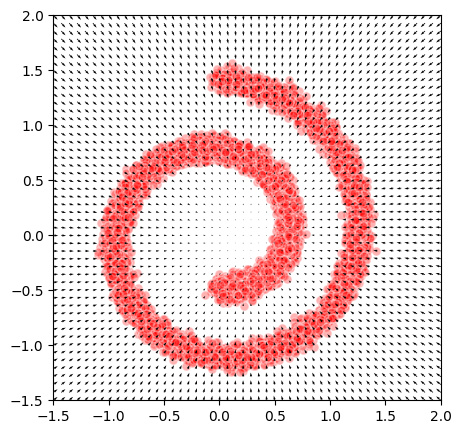

**Task 5:** What do you observe from the gradient map? What does it tell you about the distribution, and why?

**Task 6**: Plug in the score into a simple deterministic sampler which implements the following iteration:
$$
\mathbf{x}_{k+1} = \mathbf{x}_k + ɛ \nabla_{\mathbf{x}}\log p(\mathbf{x}_k)
$$

Start at point $(1.5, 1.5)$ at $k=0$, and plot the trail of dynamics resulting from the above iteration.

In [ ]:
def sample_simple(model, x, n_steps=20, eps=1e-3):
    x_sequence = [x.unsqueeze(0)]
    # TODO: Task 6. For each step, compute the next sample using the Langevin dynamics and append it to the `x_sequence` list.
    # (remember to detach the tensor before appending it to the list and to call .cpu() on it)
    return torch.cat(x_sequence).detach()


starting_point = torch.tensor([1.5, 1.5], dtype=torch.float32, device=device)
est_samples = sample_simple(model, x=starting_point, n_steps=20, eps=1e-2)
gt_samples = data.T

plot_gradients(model, data)
plt.scatter(est_samples[:, 0], est_samples[:, 1], color="green", edgecolor="white", s=50)
deltas = est_samples[1:] - est_samples[:-1]
deltas = deltas - deltas / np.linalg.norm(deltas, keepdims=True, axis=-1) * 0.04
for i, arrow in enumerate(deltas):
    plt.arrow(
        est_samples[i, 0],
        est_samples[i, 1],
        arrow[0],
        arrow[1],
        width=1e-4,
        head_width=2e-2,
        color="green",
        linewidth=3,
    )